## 1. Importと定数定義

In [1]:
import torch
from torchvision import transforms, datasets
from torchvision.models.resnet import BasicBlock, resnet18, Bottleneck
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import wandb
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import wandb

In [2]:
BATCH_SIZE = 128
LR = 1e-3
MIN_LR = 1e-5
NUM_WORKERS = 8
EPOCHS = 60
NAME = "exp003"

## 2. Datasetsを読み込む

In [3]:
# 学習用データセット
train_datasets = datasets.CIFAR10(
    "data/",
    train=True,
    download=True,
    transform=transforms.Compose([        
        transforms.Resize(128),
        transforms.ToTensor(),
        transforms.ConvertImageDtype(dtype=torch.uint8),
        transforms.RandomApply(
            p=0.4,
            transforms=[
                transforms.RandomRotation(degrees=45),
            ]
        ),
        transforms.RandomPosterize(bits=6, p=0.15),
        transforms.RandomPerspective(p=0.3),        
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.RandomVerticalFlip(p=0.4),
        transforms.ConvertImageDtype(dtype=torch.float32),
        transforms.Normalize(
            mean=[0.43146829, 0.43438266, 0.40927926],
            std=[0.03874232, 0.04122919, 0.04268689],
        ),        
    ])
)
# 検証用データセット
val_datasets = datasets.CIFAR10(
    "data/",
    train=False,
    download=True,
    transform=transforms.Compose([        
        transforms.Resize(128),        
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.43146829, 0.43438266, 0.40927926],
            std=[0.03874232, 0.04122919, 0.04268689],
        ),
    ])
)

Files already downloaded and verified
Files already downloaded and verified


## 3. Modelの用意

In [4]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)             
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.pooling1 = nn.MaxPool2d((3, 3), stride=2, padding=1)
        self.layer1 = nn.Sequential(
            BasicBlock(
                64,
                64,
            ),
            BasicBlock(
                64,
                64,
            ),
        )
        self.layer2 = nn.Sequential(
            BasicBlock(
                64,
                128,
                downsample=nn.Sequential(
                    nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
                    nn.BatchNorm2d(128),
                ),
                stride=2,
            ),
            BasicBlock(
                128,
                128,
            ),
        )
        self.layer3 = nn.Sequential(            
            BasicBlock(
                128,
                256,
                downsample=nn.Sequential(
                    nn.Conv2d(128, 256, kernel_size=1, stride=2, bias=False),
                    nn.BatchNorm2d(256),
                ),
                stride=2,
            ),
            BasicBlock(
                256,
                256,                
            ),
        )      
        self.layer4 = nn.Sequential(            
            BasicBlock(
                256,
                512,
                downsample=nn.Sequential(
                    nn.Conv2d(256, 512, kernel_size=1, stride=2, bias=False),
                    nn.BatchNorm2d(512),
                ),
                stride=2
            ),
            BasicBlock(
                512,
                512,                
            ),
        )
        self.fc = nn.Sequential(
            nn.Linear(
                512,            
                128,
            ),
            nn.Linear( 
                128,
                10,
            ),
        )
        self.activation = nn.LogSoftmax(dim=1)
        
    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        x = self.pooling1(x)
        x = self.layer1(x)
        x = self.layer2(x)        
        x = self.layer3(x)
        x = self.layer4(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        out = self.activation(x)
        return out

### ネットワークの確認（任意）
Cyfar10の入力画像は32×32pxなので同様の形状でネットワークに入力をして、出力が(BATCH_SIZE, 10)の形状のテンソルであることを確認する

In [5]:
input_image, input_label = val_datasets[40]
input_image.shape

torch.Size([3, 128, 128])

In [6]:
input_label = torch.tensor([input_label])

In [7]:
imgs = input_image.unsqueeze(dim=0)
labels = input_label.unsqueeze(dim=0)
model = Model()
outs = model(imgs)
outs

tensor([[-2.1346, -1.9942, -2.7719, -2.1671, -2.0068, -2.6247, -2.2049, -2.3919,
         -2.3811, -2.6960]], grad_fn=<LogSoftmaxBackward0>)

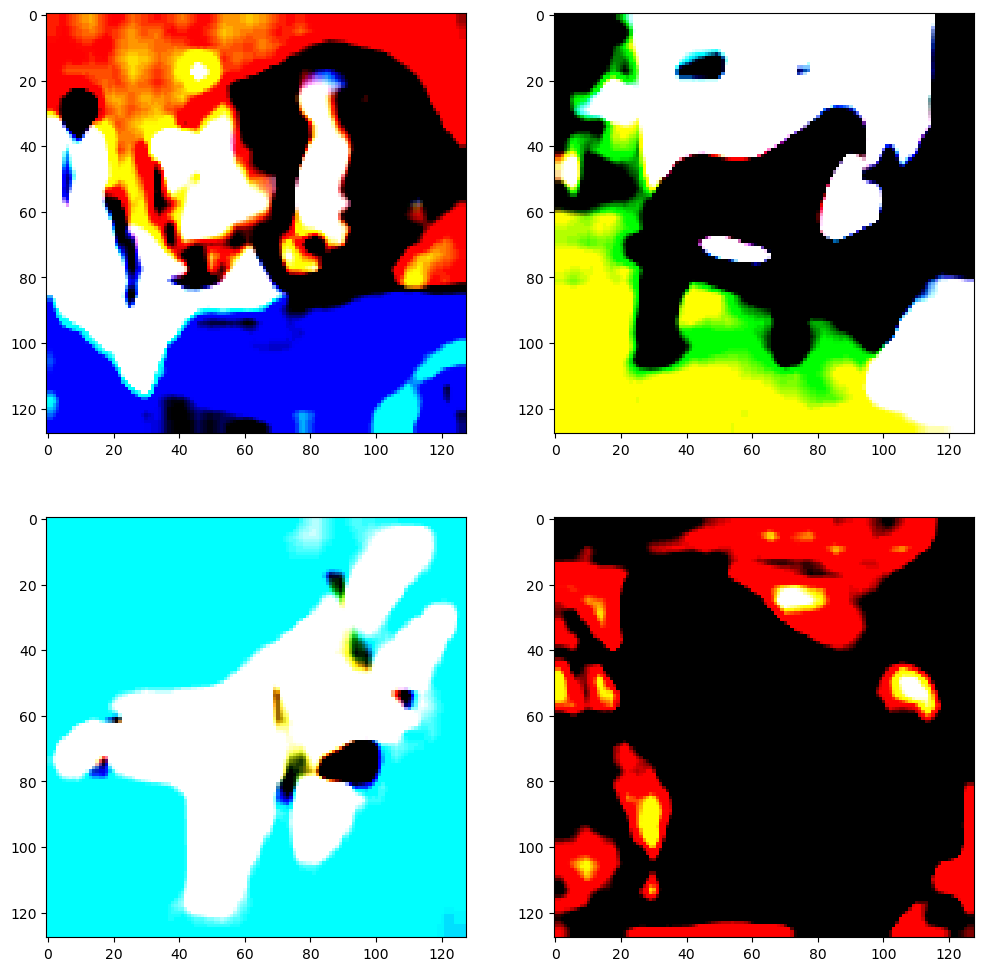

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i in range(2):
    for j in range(2):
        axes[i][j].imshow(val_datasets[10 * (i + j * 2)][0].permute(1, 2, 0).numpy().clip(0, 1))

## 4.学習 & 検証

### 学習に必要な要素の準備

In [9]:
### wandbの設定
wandb.init(
    project="csg-training",    
    name="cyfar10",
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fummicc1. Use `wandb login --relogin` to force relogin


In [10]:
# デバイス
device = torch.device("cuda")

# 深層学習モデル
model = Model()
model = nn.DataParallel(model)
model = model.to(device)

# 損失関数
loss_fn = nn.NLLLoss() # nn.LogSoftmax + nn.NLLLoss == 交差クロスエントロピー

# 最適化関数
optimizer = optim.AdamW(model.parameters(), lr=LR)

# 学習率スケジューラ
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
    eta_min=MIN_LR,
)

# データローダ
# 学習用
train_dataloader = DataLoader(
    train_datasets,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)
# 検証用
val_dataloader = DataLoader(
    val_datasets,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
)

### 学習 & 検証

In [11]:
results = [
    {
        "train": {},
        "val": {}
    } for i in range(EPOCHS)
]

In [12]:
for epoch in tqdm(range(EPOCHS)):
    model.train()
    epoch_loss = 0
    correct_counts = 0
    for imgs, labels in tqdm(train_dataloader, leave=False):        
        optimizer.zero_grad()
        imgs = imgs.to(device)
        labels = labels.to(device)
        with torch.autocast(device_type="cuda"):
            outs = model(imgs)
            loss = loss_fn(outs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()    
        preds = torch.argmax(outs, dim=1)
        correct_counts += (preds == labels).sum().item()
    lr_scheduler.step()
    acc = correct_counts / len(train_datasets)
    epoch_loss = epoch_loss / len(train_datasets)
    print(f"epoch: {epoch}, train loss: {epoch_loss:.5f}. train acc: {acc:.3f}")
    results[epoch]["train"]["acc"] = acc
    results[epoch]["train"]["loss"] = epoch_loss
    with torch.no_grad():
        model.eval()
        correct_counts = 0
        for imgs, labels in tqdm(val_dataloader, leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)
            outs = model(imgs)
            preds = torch.argmax(outs, dim=1)
            correct_counts += (preds == labels).sum().item()
        acc = correct_counts / len(val_datasets)
        print(f"epoch: {epoch}, val acc: {acc:.3f}")
        results[epoch]["val"]["acc"] = acc            
    wandb.log(results[epoch])

  0%|          | 0/60 [00:00<?, ?it/s]

epoch: 0, train loss: 0.01378. train acc: 0.347


  2%|▏         | 1/60 [00:42<41:19, 42.03s/it]

epoch: 0, val acc: 0.423


epoch: 1, train loss: 0.01152. train acc: 0.461


  3%|▎         | 2/60 [01:14<35:05, 36.30s/it]

epoch: 1, val acc: 0.497


epoch: 2, train loss: 0.01022. train acc: 0.527


  5%|▌         | 3/60 [01:46<32:49, 34.54s/it]

epoch: 2, val acc: 0.552


epoch: 3, train loss: 0.00926. train acc: 0.575


  7%|▋         | 4/60 [02:19<31:24, 33.65s/it]

epoch: 3, val acc: 0.635


epoch: 4, train loss: 0.00846. train acc: 0.615


  8%|▊         | 5/60 [02:51<30:23, 33.15s/it]

epoch: 4, val acc: 0.652


epoch: 5, train loss: 0.00792. train acc: 0.640


 10%|█         | 6/60 [03:23<29:32, 32.82s/it]

epoch: 5, val acc: 0.668


epoch: 6, train loss: 0.00744. train acc: 0.662


 12%|█▏        | 7/60 [03:55<28:51, 32.66s/it]

epoch: 6, val acc: 0.707


epoch: 7, train loss: 0.00700. train acc: 0.684


 13%|█▎        | 8/60 [04:28<28:10, 32.51s/it]

epoch: 7, val acc: 0.736


epoch: 8, train loss: 0.00662. train acc: 0.701


 15%|█▌        | 9/60 [05:00<27:34, 32.44s/it]

epoch: 8, val acc: 0.731


epoch: 9, train loss: 0.00623. train acc: 0.719


 17%|█▋        | 10/60 [05:32<26:57, 32.35s/it]

epoch: 9, val acc: 0.775


epoch: 10, train loss: 0.00596. train acc: 0.732


 18%|█▊        | 11/60 [06:04<26:22, 32.29s/it]

epoch: 10, val acc: 0.775


epoch: 11, train loss: 0.00566. train acc: 0.747


 20%|██        | 12/60 [06:36<25:44, 32.18s/it]

epoch: 11, val acc: 0.786


epoch: 12, train loss: 0.00548. train acc: 0.754


 22%|██▏       | 13/60 [07:08<25:13, 32.21s/it]

epoch: 12, val acc: 0.807


epoch: 13, train loss: 0.00519. train acc: 0.768


 23%|██▎       | 14/60 [07:40<24:38, 32.13s/it]

epoch: 13, val acc: 0.794


epoch: 14, train loss: 0.00492. train acc: 0.779


 25%|██▌       | 15/60 [08:12<24:04, 32.10s/it]

epoch: 14, val acc: 0.812


epoch: 15, train loss: 0.00478. train acc: 0.785


 27%|██▋       | 16/60 [08:44<23:30, 32.06s/it]

epoch: 15, val acc: 0.821


epoch: 16, train loss: 0.00455. train acc: 0.796


 28%|██▊       | 17/60 [09:17<23:00, 32.11s/it]

epoch: 16, val acc: 0.827


epoch: 17, train loss: 0.00439. train acc: 0.802


 30%|███       | 18/60 [09:49<22:28, 32.10s/it]

epoch: 17, val acc: 0.837


epoch: 18, train loss: 0.00424. train acc: 0.808


 32%|███▏      | 19/60 [10:21<21:57, 32.13s/it]

epoch: 18, val acc: 0.837


epoch: 19, train loss: 0.00408. train acc: 0.819


 33%|███▎      | 20/60 [10:53<21:24, 32.11s/it]

epoch: 19, val acc: 0.840


epoch: 20, train loss: 0.00388. train acc: 0.827


 35%|███▌      | 21/60 [11:25<20:52, 32.12s/it]

epoch: 20, val acc: 0.852


epoch: 21, train loss: 0.00379. train acc: 0.829


 37%|███▋      | 22/60 [11:57<20:22, 32.17s/it]

epoch: 21, val acc: 0.844


epoch: 22, train loss: 0.00363. train acc: 0.838


 38%|███▊      | 23/60 [12:29<19:49, 32.15s/it]

epoch: 22, val acc: 0.865


epoch: 23, train loss: 0.00347. train acc: 0.847


 40%|████      | 24/60 [13:01<19:16, 32.13s/it]

epoch: 23, val acc: 0.853


epoch: 24, train loss: 0.00333. train acc: 0.851


 42%|████▏     | 25/60 [13:34<18:47, 32.21s/it]

epoch: 24, val acc: 0.858


epoch: 25, train loss: 0.00323. train acc: 0.854


 43%|████▎     | 26/60 [14:06<18:14, 32.18s/it]

epoch: 25, val acc: 0.868


epoch: 26, train loss: 0.00314. train acc: 0.857


 45%|████▌     | 27/60 [14:38<17:42, 32.18s/it]

epoch: 26, val acc: 0.863


epoch: 27, train loss: 0.00301. train acc: 0.865


 47%|████▋     | 28/60 [15:10<17:07, 32.11s/it]

epoch: 27, val acc: 0.873


epoch: 28, train loss: 0.00288. train acc: 0.871


 48%|████▊     | 29/60 [15:42<16:34, 32.10s/it]

epoch: 28, val acc: 0.872


epoch: 29, train loss: 0.00277. train acc: 0.875


 50%|█████     | 30/60 [16:14<16:04, 32.16s/it]

epoch: 29, val acc: 0.882


epoch: 30, train loss: 0.00268. train acc: 0.882


 52%|█████▏    | 31/60 [16:47<15:32, 32.16s/it]

epoch: 30, val acc: 0.879


epoch: 31, train loss: 0.00256. train acc: 0.885


 53%|█████▎    | 32/60 [17:19<15:00, 32.17s/it]

epoch: 31, val acc: 0.879


epoch: 32, train loss: 0.00250. train acc: 0.887


 55%|█████▌    | 33/60 [17:51<14:29, 32.21s/it]

epoch: 32, val acc: 0.884


epoch: 33, train loss: 0.00240. train acc: 0.893


 57%|█████▋    | 34/60 [18:23<13:57, 32.22s/it]

epoch: 33, val acc: 0.887


epoch: 34, train loss: 0.00232. train acc: 0.896


 58%|█████▊    | 35/60 [18:55<13:24, 32.19s/it]

epoch: 34, val acc: 0.887


epoch: 35, train loss: 0.00225. train acc: 0.899


 60%|██████    | 36/60 [19:28<12:52, 32.21s/it]

epoch: 35, val acc: 0.892


epoch: 36, train loss: 0.00215. train acc: 0.904


 62%|██████▏   | 37/60 [20:00<12:21, 32.26s/it]

epoch: 36, val acc: 0.889


epoch: 37, train loss: 0.00209. train acc: 0.906


 63%|██████▎   | 38/60 [20:32<11:49, 32.25s/it]

epoch: 37, val acc: 0.886


epoch: 38, train loss: 0.00202. train acc: 0.909


 65%|██████▌   | 39/60 [21:04<11:15, 32.17s/it]

epoch: 38, val acc: 0.884


epoch: 39, train loss: 0.00196. train acc: 0.913


 67%|██████▋   | 40/60 [21:37<10:44, 32.21s/it]

epoch: 39, val acc: 0.892


epoch: 40, train loss: 0.00189. train acc: 0.917


 68%|██████▊   | 41/60 [22:09<10:12, 32.23s/it]

epoch: 40, val acc: 0.890


epoch: 41, train loss: 0.00182. train acc: 0.918


 70%|███████   | 42/60 [22:41<09:39, 32.21s/it]

epoch: 41, val acc: 0.897


epoch: 42, train loss: 0.00177. train acc: 0.921


 72%|███████▏  | 43/60 [23:13<09:06, 32.16s/it]

epoch: 42, val acc: 0.901


epoch: 43, train loss: 0.00170. train acc: 0.924


 73%|███████▎  | 44/60 [23:45<08:33, 32.11s/it]

epoch: 43, val acc: 0.899


epoch: 44, train loss: 0.00162. train acc: 0.928


 75%|███████▌  | 45/60 [24:17<08:02, 32.16s/it]

epoch: 44, val acc: 0.897


epoch: 45, train loss: 0.00162. train acc: 0.928


 77%|███████▋  | 46/60 [24:50<07:30, 32.18s/it]

epoch: 45, val acc: 0.899


epoch: 46, train loss: 0.00159. train acc: 0.929


 78%|███████▊  | 47/60 [25:22<06:59, 32.24s/it]

epoch: 46, val acc: 0.903


epoch: 47, train loss: 0.00152. train acc: 0.932


 80%|████████  | 48/60 [25:54<06:26, 32.20s/it]

epoch: 47, val acc: 0.904


epoch: 48, train loss: 0.00153. train acc: 0.933


 82%|████████▏ | 49/60 [26:26<05:54, 32.20s/it]

epoch: 48, val acc: 0.903


epoch: 49, train loss: 0.00149. train acc: 0.935


 83%|████████▎ | 50/60 [26:58<05:21, 32.15s/it]

epoch: 49, val acc: 0.902


epoch: 50, train loss: 0.00144. train acc: 0.936


 85%|████████▌ | 51/60 [27:31<04:49, 32.21s/it]

epoch: 50, val acc: 0.907


epoch: 51, train loss: 0.00140. train acc: 0.938


 87%|████████▋ | 52/60 [28:03<04:17, 32.19s/it]

epoch: 51, val acc: 0.907


epoch: 52, train loss: 0.00136. train acc: 0.939


 88%|████████▊ | 53/60 [28:35<03:45, 32.15s/it]

epoch: 52, val acc: 0.907


epoch: 53, train loss: 0.00135. train acc: 0.941


 90%|█████████ | 54/60 [29:07<03:12, 32.12s/it]

epoch: 53, val acc: 0.907


epoch: 54, train loss: 0.00135. train acc: 0.940


 92%|█████████▏| 55/60 [29:39<02:40, 32.10s/it]

epoch: 54, val acc: 0.906


epoch: 55, train loss: 0.00133. train acc: 0.941


 93%|█████████▎| 56/60 [30:11<02:08, 32.12s/it]

epoch: 55, val acc: 0.908


epoch: 56, train loss: 0.00132. train acc: 0.942


 95%|█████████▌| 57/60 [30:43<01:36, 32.07s/it]

epoch: 56, val acc: 0.907


epoch: 57, train loss: 0.00132. train acc: 0.941


 97%|█████████▋| 58/60 [31:15<01:04, 32.09s/it]

epoch: 57, val acc: 0.908


epoch: 58, train loss: 0.00133. train acc: 0.940


 98%|█████████▊| 59/60 [31:47<00:32, 32.07s/it]

epoch: 58, val acc: 0.909


epoch: 59, train loss: 0.00127. train acc: 0.944


100%|██████████| 60/60 [32:20<00:00, 32.34s/it]

epoch: 59, val acc: 0.908


# 5.可視化

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


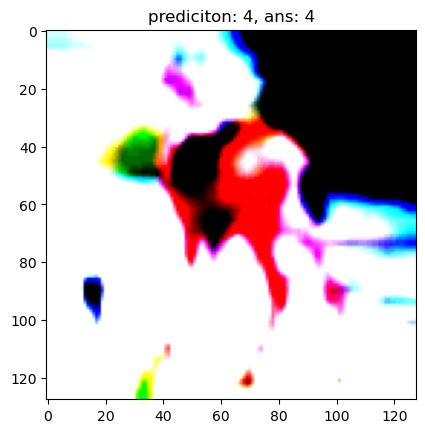

In [13]:
img, label = val_datasets[100]
outs = model(img.unsqueeze(dim=0))

predict_label = torch.argmax(outs, dim=1)[0].item()
img = img.permute((1, 2, 0)).numpy()
plt.imshow(img, cmap="gray")
plt.title(f"prediciton: {predict_label}, ans: {label}")
plt.show()

In [14]:
train_acc = []
train_loss = []
val_acc = []
for result in results:
    train_acc.append(result["train"]["acc"])
    train_loss.append(result["train"]["loss"])
    val_acc.append(result["val"]["acc"])

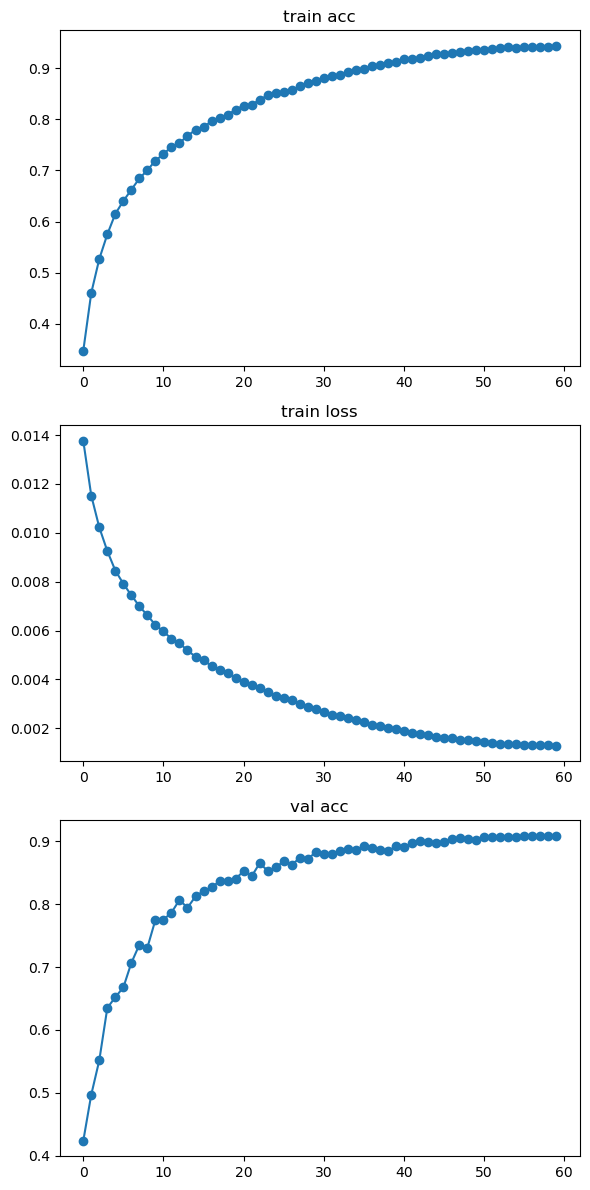

In [15]:
x = np.array(range(EPOCHS))
fig, axes = plt.subplots(3, 1, figsize=(6, 12))

axes[0].plot(x, train_acc, marker="o")
axes[0].set_title("train acc")
axes[1].plot(x, train_loss, marker="o")
axes[1].set_title("train loss")
axes[2].plot(x, val_acc, marker="o")
axes[2].set_title("val acc")
fig.tight_layout()
fig.show()